# Stock Price Prediction End To End ML App

Based on "Machine Learning Project in Python to Predict Stock Price ML End to End Application"

- PyTorch (Not TF)
- yfinance (for now just use NASDAQ directly)
- matplotlib
- numpy
- pandas
- streamlit (?)

**Contributor**: James Guzman

**Teammates**: Josef, Anshul

**Project Advisor**: Dr. Magdalini Eirinaki

**SJSU CMPE 256**: Advanced Data Mining

**Date**: Nov 17, 2023

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
# import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# import streamlit
    # streamlit they use to deploy as a web app, for now I will use Wave or PySide6

In [2]:
LEARNING_RATE = 1e-2
BATCH_SIZE = 4
TEST_BATCH_SIZE = 1
NUM_EPOCHS = 5
DEBUG = True

dataset_name = "stock_closing_price"

In [3]:
train_mse_loss_avg_values = []
train_rmse_loss_avg_values = []

valid_mse_loss_avg_values = []
valid_rmse_loss_avg_values = []

## Helper Classes & Functions

In [4]:
def mkdir_prep_dir(dirpath):
    """make preprocess directory if doesn't exist"""
    prep_dir = dirpath
    if not os.path.exists(prep_dir):
        os.makedirs(prep_dir)
    return prep_dir

def save_checkpoint(state, filename="best_lstm.pth.tar"):
    print("=> Saving Checkpoint")
    torch.save(state, filename)

def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))


In [5]:
# Ideally, I am thinking of parts of the preprocessing pipeline code, I can refactor toward nifi later
# Need a better telemetry dashboard to interact with NiFi: Unity, H2O Wave, PySide6 QT
class DataPrepPipeline:
    def __init__(self):
        pass

    # NOTE (JG): my save predictions method later should be based on how we address 100 days here
    def split_features_labels(self, stock_features_labels_data, num_days=100):
        # num_days = 100 by default
        x_features_2d_list = [] # features: ex 100 days of final closing prices
        y_labels_list = [] # labels: ex 100th day of final closing price gt to be pred

        count = 0
        for i in range(num_days, stock_features_labels_data.shape[0]):
            # x_features_list is a 2D list where each element of 100 elements are 1D array with single element
            if DEBUG and count == 0:
                print(f"stock_features_labels_data[i-num_days:i] = {stock_features_labels_data[i-num_days:i]}")

            x_features_per_num_days = []
            for j in range(len(stock_features_labels_data[i-num_days:i])):
                if DEBUG and count == 0:
                    print(f"j = {j}")
                    print(f"stock_features_labels_data[j][0] = {stock_features_labels_data[j][0]}") # only one item per list within list
                x_features_per_num_days.append(stock_features_labels_data[j][0])
            x_features_2d_list.append(x_features_per_num_days)
            if DEBUG and count == 0:
                print(f"x_features_2d_list = {x_features_2d_list}")
            y_labels_list.append(stock_features_labels_data[i,0])
            count += 1

        return x_features_2d_list, y_labels_list

In [97]:
class PyTorchPipeline:
    def __init__(self):
        pass

    def train_model(self, train_loader, lstm_model, optimizer, loss_criterion):
        train_loop = tqdm(train_loader)

        train_mse_loss_values = []
        train_rmse_loss_values = []

        # closing_price_2d_tensor
        for batch_idx, (closing_price_2d_tensor, final_closing_price_tensor) in enumerate(train_loop):
            final_closing_price_tensor_gt = final_closing_price_tensor.unsqueeze(1)

            optimizer.zero_grad()
            pred_final_closing_price = lstm_model(closing_price_2d_tensor)
            mse_loss = loss_criterion(pred_final_closing_price, final_closing_price_tensor_gt)
            rmse_loss = rmse(pred_final_closing_price, final_closing_price_tensor_gt)

            mse_loss.backward()
            optimizer.step()

            train_mse_loss_values.append(mse_loss.item())
            train_rmse_loss_values.append(rmse_loss.item())

            train_loop.set_postfix(train_mse_loss=mse_loss.item(), train_rmse_loss=rmse_loss.item())

        train_mse_loss_avg_values.append( sum(train_mse_loss_values)/len(train_loader) )
        train_rmse_loss_avg_values.append( sum(train_rmse_loss_values)/len(train_loader) )

    def validate_model(self, val_loader, lstm_model, loss_criterion):
        val_loop = tqdm(val_loader)

        val_mse_loss_values = []
        val_rmse_loss_values = []

        for batch_idx, (closing_price_2d_tensor, final_closing_price_tensor) in enumerate(val_loop):
            final_closing_price_tensor_gt = final_closing_price_tensor.unsqueeze(1)

            pred_final_closing_price = lstm_model(closing_price_2d_tensor)
            mse_loss = loss_criterion(pred_final_closing_price, final_closing_price_tensor_gt)
            rmse_loss = rmse(pred_final_closing_price, final_closing_price_tensor_gt)


            val_mse_loss_values.append(mse_loss.item())
            val_rmse_loss_values.append(rmse_loss.item())

            val_loop.set_postfix(val_mse_loss=mse_loss.item(), val_rmse_loss=rmse_loss.item())

        valid_mse_loss_avg_values.append( sum(val_mse_loss_values)/len(val_loader) )
        valid_rmse_loss_avg_values.append( sum(val_rmse_loss_values)/len(val_loader) )

    def train_over_epochs(self, train_loader, test_loader, lstm_model, optimizer, loss_criterion, dst_folder="lstm_model"):
        step = 100
        for epoch in range(NUM_EPOCHS):
            self.train_model(train_loader, lstm_model, optimizer, loss_criterion)

            checkpoint = {
                "state_dict": lstm_model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }

            mkdir_prep_dir(f"{dataset_name}/{dst_folder}")
            filename = f"{dataset_name}/{dst_folder}/lstm_model_{step}.pth.tar"
            save_checkpoint(checkpoint, filename=filename)

            self.validate_model(test_loader, lstm_model, loss_criterion)

            step += 100

    def deploy_model(self, test_loader, lstm_model):
        test_loop = tqdm(test_loader)
        final_closing_price_predictions = []
        count = 0

        for batch_idx, (closing_price_2d_tensor, final_closing_price_tensor) in enumerate(test_loop):
            final_closing_price_pred = lstm_model(closing_price_2d_tensor)
            if DEBUG and count == 0:
                print(f"final_closing_price_pred = {final_closing_price_pred}")
            final_closing_price_predictions.append(final_closing_price_pred.item())
            count += 1
        return final_closing_price_predictions

In [94]:
class PyTorchUtility:
    def __init__(self):
        pass

    # TODO (JG): Add arguments for naming the two labels
    def plot_loss_curves(self, train_loss_values, test_loss_values, plot_title, plot_filename):
        f, ax = plt.subplots()
        ax.set_title(plot_title)
        ax.plot(train_loss_values, color="blue", label="Train RMSE")
        ax.plot(test_loss_values, color="gold", label="Valid RMSE")
        ax.grid(True)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("RMSE Loss")
        plt.legend()
        plt.savefig(plot_filename)
        plt.show()


    # TODO (JG): Need to check num_days preds for closing price. Is it suppose to be over
    def save_lstm_predictions(self, stock_test_date_df, final_closing_price_predictions, num_days, dst_folder="lstm_model", filename="pytorch_final_closing_price_preds.csv"):
        # test_close_price_df, google_stock_train_date
        stock_date_list = []
        # y_train_list = []

        count = 0
        for i in range(num_days, stock_test_date_df.shape[0]):
            # if DEBUG and count == 0:
            #     print(f"stock_test_date_df[0] = {stock_test_date_df[0]}")
            #     print(f"stock_test_date_df[i,0] = {stock_test_date_df[i,0]}")
                
            stock_pred_date_id = stock_test_date_df.Date.iloc[i]
            if DEBUG and count == 0:
                print(f"stock_pred_date_id = {stock_pred_date_id}")
            stock_date_list.append(stock_pred_date_id)
            count += 1

        mkdir_prep_dir(f"{dataset_name}/{dst_folder}")
        dst_filepath = f"{dataset_name}/{dst_folder}/{filename}"
        
        # final close price pred for each 100th date after predicting on 100 days of final closing prices
        stock_close_price_res_df = pd.DataFrame({f"{num_days}th Date": stock_date_list, "Close": final_closing_price_predictions})
        stock_close_price_res_df.to_csv(dst_filepath, index=False)
        return stock_close_price_res_df


## Load NASDAQ Symbols Metadata

In [8]:
# Load Stock Market Data
nasdaq_meta_symbols_filepath = "/home/james/src/datasets/NASDAQ_Yahoo_Finance/symbols_valid_meta.csv"

In [9]:
nasdaq_symbols_meta_pd = pd.read_csv(nasdaq_meta_symbols_filepath)

In [10]:
nasdaq_symbols_meta_pd.head()

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
2,Y,AAAU,Perth Mint Physical Gold ETF,P,,Y,100.0,N,NaN,AAAU,AAAU,N
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100.0,N,N,NaN,AACG,N
4,Y,AADR,AdvisorShares Dorsey Wright ADR ETF,P,,Y,100.0,N,NaN,AADR,AADR,N


In [11]:
nasdaq_symbols_meta_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8049 entries, 0 to 8048
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nasdaq Traded     8049 non-null   object 
 1   Symbol            8049 non-null   object 
 2   Security Name     8049 non-null   object 
 3   Listing Exchange  8049 non-null   object 
 4   Market Category   8049 non-null   object 
 5   ETF               8049 non-null   object 
 6   Round Lot Size    8049 non-null   float64
 7   Test Issue        8049 non-null   object 
 8   Financial Status  3383 non-null   object 
 9   CQS Symbol        4666 non-null   object 
 10  NASDAQ Symbol     8049 non-null   object 
 11  NextShares        8049 non-null   object 
dtypes: float64(1), object(11)
memory usage: 754.7+ KB


## Load NASDAQ Stock Data If Company Is In Metadata

In [12]:
stock_dir_path = "/home/james/src/datasets/NASDAQ_Yahoo_Finance/stocks"

In [13]:
symbol_name = "GOOG"

In [14]:
if symbol_name in nasdaq_symbols_meta_pd["Symbol"].tolist():
    print(f"{symbol_name} is in NASDAQ Yahoo Finance Metadata, loading GOOG stock pd")
    google_stock_data_pd = pd.read_csv(os.path.join(stock_dir_path, f"{symbol_name}.csv"))

GOOG is in NASDAQ Yahoo Finance Metadata, loading GOOG stock pd


In [15]:
google_stock_data_pd.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [16]:
google_stock_data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3932 entries, 0 to 3931
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3932 non-null   object 
 1   Open       3932 non-null   float64
 2   High       3932 non-null   float64
 3   Low        3932 non-null   float64
 4   Close      3932 non-null   float64
 5   Adj Close  3932 non-null   float64
 6   Volume     3932 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 215.2+ KB


## Create Moving Average Stock Across 100 Days

We'll create moving average stock across 100 days

In [17]:
num_days = 100

In [18]:
mavg_100_days = google_stock_data_pd.Close.rolling(num_days).mean()

### Plot Moving Average vs Close Price

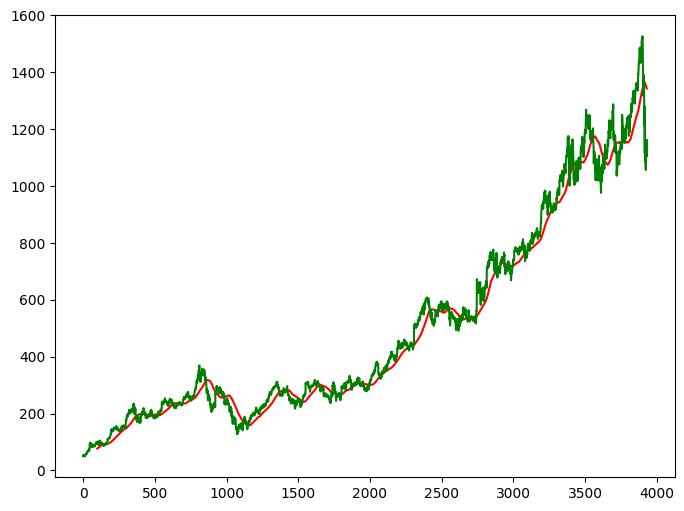

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(mavg_100_days, "r")
plt.plot(google_stock_data_pd.Close, "g")
plt.show()

## Create Moving Average Stock Across 200 Days

In [20]:
num_days = 200
mavg_200_days = google_stock_data_pd.Close.rolling(num_days).mean()

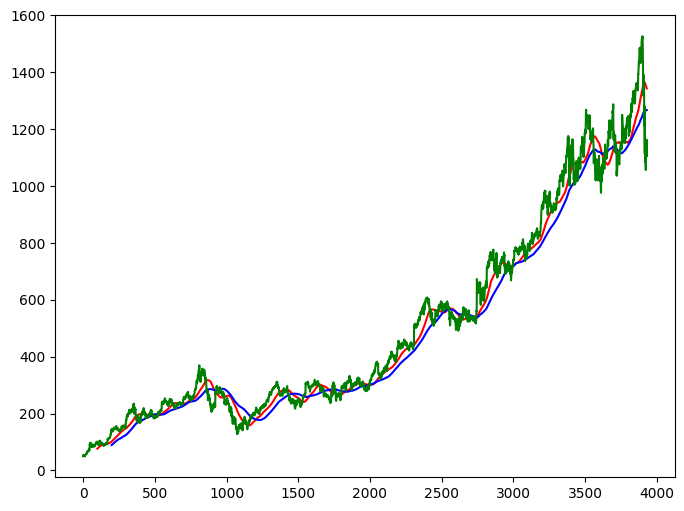

In [21]:
plt.figure(figsize=(8,6))
plt.plot(mavg_100_days, "r")
plt.plot(mavg_200_days, "b")
plt.plot(google_stock_data_pd.Close, "g")
plt.show()

## Clean NAs from Stock Data

Double check how to find number of NAs

In [22]:
google_stock_data_pd.dropna(inplace=True)

## Split Stock 80% for Train & 20% for Test

In [23]:
train_ratio = 0.60
valid_ratio = 0.20 + train_ratio # 0.80
test_ratio = 0.20

In [24]:
# 60% for training: 0 to 60%
google_stock_train = pd.DataFrame(google_stock_data_pd.Close[0: int(len(google_stock_data_pd)*train_ratio)])
# further split training set to 80% training & 20% validation
# google_stock_train = pd.DataFrame(google_stock_training_set[0: int(len(google_stock_training_set)*0.80)])
# google_stock_valid = pd.DataFrame(google_stock_training_set[int(len(google_stock_training_set)*0.80: len(google_stock_training_set)])

# 20% for validation: 60% to 80%
google_stock_valid = pd.DataFrame(google_stock_data_pd.Close[int(len(google_stock_data_pd)*train_ratio): int(len(google_stock_data_pd)*valid_ratio)])

google_stock_test = pd.DataFrame(google_stock_data_pd.Close[int(len(google_stock_data_pd)*valid_ratio): len(google_stock_data_pd)])

In [25]:
google_stock_train_date = pd.DataFrame(google_stock_data_pd.Date[0: int(len(google_stock_data_pd)*0.80)])
google_stock_test_date = pd.DataFrame(google_stock_data_pd.Date[int(len(google_stock_data_pd)*0.80): len(google_stock_data_pd)])

In [83]:
google_stock_test_date.shape

(787, 1)

In [93]:
print(google_stock_test_date.Date.iloc[0])

2017-02-15


In [26]:
# We dont see 100 since back at google_stock_train, we havent yet split features from labels
google_stock_train.shape

(2359, 1)

In [27]:
google_stock_train.shape[0]

2359

In [28]:
google_stock_valid.shape[0]

786

In [29]:
google_stock_test.shape[0]

787

In [30]:
print(f"len(google_stock_data_pd) = {len(google_stock_data_pd)}")
print(f"total google stock on splits = {google_stock_train.shape[0] + google_stock_valid.shape[0] + google_stock_test.shape[0]}")

len(google_stock_data_pd) = 3932
total google stock on splits = 3932


## MinMaxScaler Feature Range

Scale training data between 0 and 1

In [31]:
scaler = MinMaxScaler(feature_range=(0,1))

In [32]:
google_stock_train_scale = scaler.fit_transform(google_stock_train)

In [33]:
google_stock_valid_scale = scaler.fit_transform(google_stock_valid)

In [34]:
google_stock_test_scale = scaler.fit_transform(google_stock_test)

In [35]:
# 10 days stock price
# it'll take the first 10 days, to then predict 11th day stock price
# 10, 11, 12, 15, 16, 17, 18, 19, 20, 17, "18"
# for the 12th day prediction, it'll take the 11th back to the 1st day
# .., 11, 12, 15, 16, 17, 18, 19, 20, 17, 18, "19"

## Array Slicing on 1st 100 Days Stock Data (Train, Test)

Previous array slicing for each training feature row has 100 samples (100 closing prices) while training label has 1 sample, which is final closing price

In [36]:
num_days = 100

In [37]:
nifi_pipeline = DataPrepPipeline()

In [38]:
x_train_fets_list, y_train_labels_list = nifi_pipeline.split_features_labels(google_stock_train_scale, num_days)

stock_features_labels_data[i-num_days:i] = [[0.00032331]
 [0.00813167]
 [0.00919957]
 [0.00476144]
 [0.00586853]
 [0.00773979]
 [0.00601548]
 [0.00195944]
 [0.00231214]
 [0.00023513]
 [0.00146958]
 [0.        ]
 [0.00153816]
 [0.00224356]
 [0.00225336]
 [0.00521211]
 [0.00733811]
 [0.01124719]
 [0.01174684]
 [0.01367689]
 [0.0171255 ]
 [0.01895758]
 [0.01746841]
 [0.01799746]
 [0.02038797]
 [0.01941805]
 [0.01787989]
 [0.02630548]
 [0.0304399 ]
 [0.02898991]
 [0.03190948]
 [0.03433918]
 [0.03758205]
 [0.03631822]
 [0.03805232]
 [0.03695503]
 [0.03453512]
 [0.03663173]
 [0.04006074]
 [0.04113844]
 [0.04320564]
 [0.04815323]
 [0.04695797]
 [0.03965906]
 [0.04836876]
 [0.07095131]
 [0.08561771]
 [0.08013128]
 [0.08421671]
 [0.09139806]
 [0.088792  ]
 [0.09407269]
 [0.09293622]
 [0.08980111]
 [0.08297247]
 [0.06793377]
 [0.07106887]
 [0.06729696]
 [0.06647399]
 [0.08132655]
 [0.08032723]
 [0.08313903]
 [0.07105907]
 [0.07101988]
 [0.06616048]
 [0.06798276]
 [0.06376996]
 [0.06614088]
 [0.0

In [39]:
x_valid_fets_list, y_valid_labels_list = nifi_pipeline.split_features_labels(google_stock_valid_scale, num_days)

stock_features_labels_data[i-num_days:i] = [[0.18370406]
 [0.17196174]
 [0.18977765]
 [0.22092632]
 [0.22435364]
 [0.20846108]
 [0.20837426]
 [0.19796243]
 [0.23616825]
 [0.23504028]
 [0.24603045]
 [0.23780226]
 [0.25684733]
 [0.25875615]
 [0.25164141]
 [0.19919157]
 [0.16650989]
 [0.19800584]
 [0.17473825]
 [0.2159084 ]
 [0.28182122]
 [0.21307413]
 [0.21991405]
 [0.22720244]
 [0.25143889]
 [0.27671648]
 [0.2701946 ]
 [0.29513979]
 [0.29009282]
 [0.30919582]
 [0.31338946]
 [0.32507385]
 [0.31272431]
 [0.31528376]
 [0.31482113]
 [0.32743096]
 [0.33826219]
 [0.33850794]
 [0.33711987]
 [0.33197171]
 [0.31323035]
 [0.33090151]
 [0.33574596]
 [0.3376982 ]
 [0.33072804]
 [0.32607158]
 [0.30932587]
 [0.31989681]
 [0.29352013]
 [0.27000678]
 [0.29791631]
 [0.3256233 ]
 [0.30825584]
 [0.3052334 ]
 [0.28481461]
 [0.24850326]
 [0.24964576]
 [0.21096277]
 [0.19081437]
 [0.19524386]
 [0.18650059]
 [0.21600142]
 [0.21553826]
 [0.22347072]
 [0.14646177]
 [0.13201541]
 [0.18050779]
 [0.20725834]
 [0.1

In [40]:
# x_train_list = []
# y_train_list = []

# for i in range(num_days, google_stock_train_scale.shape[0]):
#     x_train_list.append(google_stock_train_scale[i-100:i])
#     y_train_list.append(google_stock_train_scale[i,0])

In [41]:
# x_train, y_train = np.array(x_train_list), np.array(y_train_list)

In [42]:
x_test_fets_list, y_test_labels_list = nifi_pipeline.split_features_labels(google_stock_test_scale, num_days)

stock_features_labels_data[i-num_days:i] = [[0.0063881 ]
 [0.01366072]
 [0.01915033]
 [0.02419058]
 [0.02292705]
 [0.02372733]
 [0.01995061]
 [0.02084918]
 [0.012327  ]
 [0.02921686]
 [0.02274452]
 [0.02056837]
 [0.01874321]
 [0.02454157]
 [0.02939938]
 [0.03404656]
 [0.04046277]
 [0.04367785]
 [0.0437902 ]
 [0.04600851]
 [0.04822683]
 [0.05291608]
 [0.04769331]
 [0.02250587]
 [0.02128441]
 [0.00442258]
 [0.        ]
 [0.00713225]
 [0.00911183]
 [0.02383958]
 [0.02396598]
 [0.02124225]
 [0.03386403]
 [0.02827621]
 [0.02383958]
 [0.01888357]
 [0.01437676]
 [0.014461  ]
 [0.01252349]
 [0.0138854 ]
 [0.01281836]
 [0.03192653]
 [0.03143517]
 [0.03338673]
 [0.03821643]
 [0.04037853]
 [0.06785446]
 [0.08124842]
 [0.08044814]
 [0.0839862 ]
 [0.12850649]
 [0.13778679]
 [0.1432202 ]
 [0.15810237]
 [0.16458876]
 [0.15822877]
 [0.16829529]
 [0.1653048 ]
 [0.16054537]
 [0.16310054]
 [0.16537498]
 [0.1721984 ]
 [0.18050995]
 [0.14768485]
 [0.16259513]
 [0.16788817]
 [0.17890939]
 [0.18868113]
 [0.1

In [43]:
x_test_fets_list

[[0.006388100020334964,
  0.013660715425727332,
  0.019150332224561417,
  0.024190578874273116,
  0.02292704667579648,
  0.023727326580955665,
  0.019950612129720602,
  0.020849181043469445,
  0.01232700127604347,
  0.029216857687541564,
  0.02274452218730838,
  0.020568367546391908,
  0.01874320835376042,
  0.02454157432255788,
  0.029399382176029665,
  0.03404655848363114,
  0.04046276556134809,
  0.04367785301842808,
  0.04379019555570873,
  0.04600851078269863,
  0.048226826009688306,
  0.05291607721111502,
  0.04769330607291544,
  0.02250586927630427,
  0.02128441197165265,
  0.004422576925288579,
  0.0,
  0.0071322515029779154,
  0.009111828126715293,
  0.02383958342598813,
  0.02396597949196,
  0.021242251385579447,
  0.03386403399514326,
  0.028276213879967704,
  0.02383958342598813,
  0.018883572256175096,
  0.014376759850988075,
  0.014460995330886517,
  0.012523493600974378,
  0.013885400500288636,
  0.012818360626742908,
  0.0319265322652309,
  0.03143517291453146,
  0.0333

In [44]:
y_test_labels_list

[0.16238458218216523,
 0.18167527830914132,
 0.18635047598187682,
 0.19874765920912751,
 0.19513941571768934,
 0.2119591758702284,
 0.2196670222038044,
 0.21582012580136167,
 0.2225170606839082,
 0.23293466728742152,
 0.19132062637262925,
 0.18724904489562566,
 0.168000509354723,
 0.1784461373233701,
 0.1629601770127631,
 0.16342351499832874,
 0.16280575958165766,
 0.15334293600665716,
 0.15939409410739835,
 0.16135961720244452,
 0.15775137371100656,
 0.15228994966180265,
 0.13030354679358047,
 0.14034205089142682,
 0.1519669755786519,
 0.1513351666332896,
 0.15799011231425886,
 0.13555442498916226,
 0.13511919406097883,
 0.12948921335973007,
 0.1548030462223131,
 0.1580462407367753,
 0.15001550601229674,
 0.14244802358113584,
 0.1395277174575762,
 0.15002947384873977,
 0.16165448422821327,
 0.1753573602400138,
 0.17256345018242603,
 0.1600820314752769,
 0.15918346256152827,
 0.17061189492382267,
 0.15734424984020556,
 0.16096654686033474,
 0.1651644387110618,
 0.16940449114786227,
 0.

In [45]:
# x_test_list = []
# y_test_list = []

# for i in range(num_days, google_stock_test_scale.shape[0]):
#     x_test_list.append(google_stock_test_scale[i-100:i])
#     y_test_list.append(google_stock_test_scale[i,0])

## Create PyTorch Nasdaq Dataset (Train, Test)

In [46]:
class NasdaqDataset(torch.utils.data.Dataset):
    def __init__(self, closing_price_2d_list, final_closing_price_list):
        self.closing_price_2d_list_ = closing_price_2d_list
        self.final_closing_price_list_ = final_closing_price_list
        self.count_ = 0

    def __len__(self):
        return len(self.closing_price_2d_list_)

    def __getitem__(self, idx):
        if DEBUG and self.count_ == 0:
            print(f"NasdaqDataset __getitem__ idx = {idx}")
        # each array holds 100 days of closing prices
        closing_price_array = self.closing_price_2d_list_[idx]
        closing_price_tensor = torch.tensor(closing_price_array).float()

        if DEBUG and self.count_ == 0:
            print(f"closing_price_tensor.shape = {closing_price_tensor.shape}")
        
        final_closing_price_array = self.final_closing_price_list_[idx]
        final_closing_price_tensor = torch.tensor(final_closing_price_array).float()

        if DEBUG and self.count_ == 0:
            print(f"final_closing_price_tensor.shape = {final_closing_price_tensor.shape}")

        self.count_ += 1
        
        return closing_price_tensor, final_closing_price_tensor

In [47]:
x_train_fets_array, y_train_labels_array = np.array(x_train_fets_list), np.array(y_train_labels_list)
x_valid_fets_array, y_valid_labels_array = np.array(x_valid_fets_list), np.array(y_valid_labels_list)
x_test_fets_array, y_test_labels_array = np.array(x_test_fets_list), np.array(y_test_labels_list)

In [48]:
stock_train_dataset = NasdaqDataset(x_train_fets_list, y_train_labels_list)

In [49]:
stock_valid_dataset = NasdaqDataset(x_valid_fets_list, y_valid_labels_list)

In [50]:
stock_test_dataset = NasdaqDataset(x_test_fets_list, y_test_labels_list)

## Create PyTorch Nasdaq DataLoader (Train, Test)

In [51]:
stock_train_loader = DataLoader(stock_train_dataset, batch_size = BATCH_SIZE, shuffle=True)

In [52]:
stock_valid_loader = DataLoader(stock_valid_dataset, batch_size = TEST_BATCH_SIZE, shuffle=False)

In [53]:
stock_test_loader = DataLoader(stock_test_dataset, batch_size = TEST_BATCH_SIZE, shuffle=False)

## Create a PyTorch LSTM Model

Based on our "x" and "y" training data, we'll create a ML model and then train it

In [54]:
# Use nn.LSTM, nn.Linear, nn.ReLU, nn.Dropout

In [55]:
# rows = 2259, columns, ch
# NOTE: use to be "x"
x_train_fets_array.shape

(2259, 100)

In [56]:
class StockPriceLSTM(nn.Module):
    def __init__(self, num_days, hidden_size=10):
        super(StockPriceLSTM, self).__init__()
        # self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.lstm1 = nn.LSTMCell(num_days, hidden_size*5)
        self.lstm2 = nn.LSTMCell(hidden_size*5, hidden_size*6)
        self.lstm3 = nn.LSTMCell(hidden_size*6, hidden_size*8)
        self.lstm4 = nn.LSTMCell(hidden_size*8, hidden_size*12)
        self.linear = nn.Linear(hidden_size*12, 1)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.dropout4 = nn.Dropout(0.5)
        self.relu = nn.ReLU()

        self.count_ = 0

    def forward(self, closing_price_2d_features):
        # closing price 2D features: row by col, each row has 100 samples since 100 days of closing prices, 
        # trying to pred final closing price
        if DEBUG and self.count_ == 0:
            print(f"type(closing_price_2d_features) = {type(closing_price_2d_features)}")
        lstm_features, lstm_hidden = self.lstm1(closing_price_2d_features)
        if DEBUG and self.count_ == 0:
            print(f"type(lstm_features) = {type(lstm_features)}")
        lstm_relu = self.relu(lstm_features)
        lstm_dropout = self.dropout1(lstm_relu)

        lstm_features, lstm_hidden = self.lstm2(lstm_dropout)
        lstm_relu = self.relu(lstm_features)
        lstm_dropout = self.dropout2(lstm_relu)

        lstm_features, lstm_hidden = self.lstm3(lstm_dropout)
        lstm_relu = self.relu(lstm_features)
        lstm_dropout = self.dropout3(lstm_relu)

        lstm_features, lstm_hidden = self.lstm4(lstm_dropout)
        lstm_relu = self.relu(lstm_features)
        lstm_dropout = self.dropout4(lstm_relu)

        stock_price_pred = self.linear(lstm_dropout)

        self.count_ += 1
        return stock_price_pred

In [57]:
lstm_model = StockPriceLSTM(num_days=x_train_fets_array.shape[1], hidden_size=10)

In [58]:
mse_criterion = nn.MSELoss()

In [59]:
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

## Train PyTorch LSTM Model using Pipeline

In [98]:
pytorch_pipeline = PyTorchPipeline()

In [61]:
pytorch_pipeline.train_over_epochs(
    stock_train_loader, stock_valid_loader,
    lstm_model,
    lstm_optimizer,
    mse_criterion,
    dst_folder="lstm_stock_close"
)

  0%|          | 0/565 [00:00<?, ?it/s]

NasdaqDataset __getitem__ idx = 989
closing_price_tensor.shape = torch.Size([100])
final_closing_price_tensor.shape = torch.Size([])
type(closing_price_2d_features) = <class 'torch.Tensor'>
type(lstm_features) = <class 'torch.Tensor'>
=> Saving Checkpoint


  0%|          | 0/686 [00:00<?, ?it/s]

NasdaqDataset __getitem__ idx = 0
closing_price_tensor.shape = torch.Size([100])
final_closing_price_tensor.shape = torch.Size([])


  0%|          | 0/565 [00:00<?, ?it/s]

=> Saving Checkpoint


  0%|          | 0/686 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]

=> Saving Checkpoint


  0%|          | 0/686 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]

=> Saving Checkpoint


  0%|          | 0/686 [00:00<?, ?it/s]

  0%|          | 0/565 [00:00<?, ?it/s]

=> Saving Checkpoint


  0%|          | 0/686 [00:00<?, ?it/s]

In [99]:
pytorch_utility = PyTorchUtility()

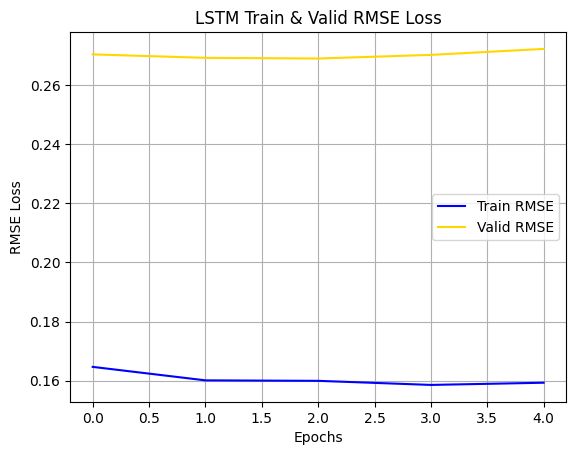

In [64]:
pytorch_utility.plot_loss_curves(train_rmse_loss_avg_values, valid_rmse_loss_avg_values,
                                 "LSTM Train & Valid RMSE Loss", "lstm_train_valid_loss_avg_curves.jpg")

In [65]:
final_train_rmse = min(train_rmse_loss_avg_values)
print(f"LSTM: final_train Min RMSE = {final_train_rmse}")

LSTM: final_train Min RMSE = 0.15856619873537425


In [66]:
final_test_rmse = min(valid_rmse_loss_avg_values)
print(f"LSTM: final_valid Min RMSE = {final_test_rmse}")

LSTM: final_valid Min RMSE = 0.2689479586204009


In [100]:
final_closing_price_predictions = pytorch_pipeline.deploy_model(stock_test_loader, lstm_model)

  0%|          | 0/687 [00:00<?, ?it/s]

final_closing_price_pred = tensor([[0.3956]], grad_fn=<AddmmBackward0>)


In [101]:
pytorch_utility.save_lstm_predictions(google_stock_test_date, final_closing_price_predictions, 
                                       num_days=100, dst_folder="lstm_stock_close/predictions/", 
                                       filename="pytorch_final_closing_price_preds.csv")

stock_pred_date_id = 2017-07-11


,100th Date,Close
0,2017-07-11,0.395577
1,2017-07-12,0.395577
2,2017-07-13,0.395577
3,2017-07-14,0.395577
4,2017-07-17,0.395577
...,...,...
682,2020-03-26,0.395577
683,2020-03-27,0.395577
684,2020-03-30,0.395577
685,2020-03-31,0.395577
